In [1]:
import torch
import monai.transforms as t
import monai.data as d
from monai.data import decollate_batch
import sys
import numpy as np
import pandas as pd
import nibabel as nib
import logging
import matplotlib.pyplot as plt
from monai.data import Dataset, DataLoader
import torch

2024-08-26 14:36:32.215638: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-26 14:36:32.271901: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-26 14:36:33.044312: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
path_scan= '/data/PANORAMA/amos22/amos22/imagesTr_noMRI/amos_0010.nii.gz'
path_label= '/data/PANORAMA/amos22/amos22/labelsTr_final/amos_0010.nii.gz'

In [3]:
data_dict = {'scan': path_scan, 'label': path_label}

In [4]:
# Cargar los archivos NIfTI
img_nifti = nib.load(path_scan)
label_nifti = nib.load(path_label)

# Obtener los datos en formato NumPy
img_data = img_nifti.get_fdata()
label_data = label_nifti.get_fdata()

primer em defineixo les funcions:

In [5]:
wl, ww = -40, 400  # https://www.stepwards.com/?page_id=21646#ABDOMINAL_WINDOW
clamp1 = t.ThresholdIntensityd(keys=('scan',), above=False, threshold=wl + (ww / 2), cval=wl + (ww / 2))
clamp2 = t.ThresholdIntensityd(keys=('scan',), above=True, threshold=wl - (ww / 2), cval=wl - (ww / 2))
norm = t.NormalizeIntensityd(keys=('scan',), nonzero=True)
intensities = t.Compose([clamp1, clamp2, norm])

In [6]:
def show_scan_and_label(scan, label, title="",cmap=None):
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    axes[0].imshow(scan, cmap='gray')
    axes[0].set_title('Scan')
    axes[1].imshow(label, cmap='jet', alpha=0.5)  # Etiqueta superpuesta con transparencia
    axes[1].set_title('Label')
    fig.suptitle(title)
    plt.show()

In [7]:
patch_size = (96, 96, 96)
n_samples = 8
neg_samples = 1
p_app = 0.1
pr_geom = 0.1
n_classes = 5

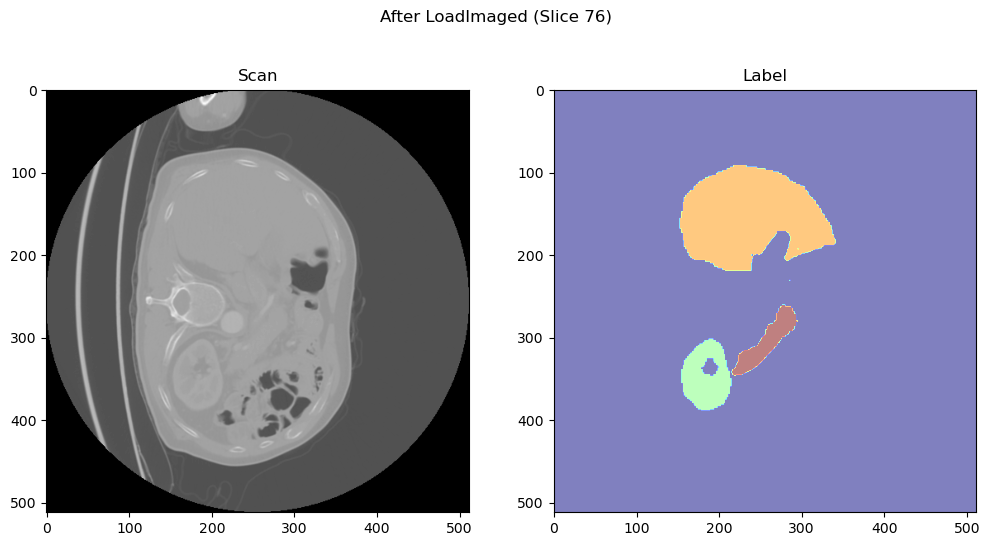

In [14]:
# 1. LoadImaged
load_transform = t.LoadImaged(keys=('scan', 'label'), ensure_channel_first=True, image_only=True)
loaded = load_transform(data_dict)
scan = loaded['scan'][0]  # Elimina la dimensión del canal para visualizar
label = loaded['label'][0]

slice_index = scan.shape[2] // 2  # Tomar la slice central como ejemplo
show_scan_and_label(scan[:, :, 76], label[:, :, 76], "After LoadImaged (Slice 76)")

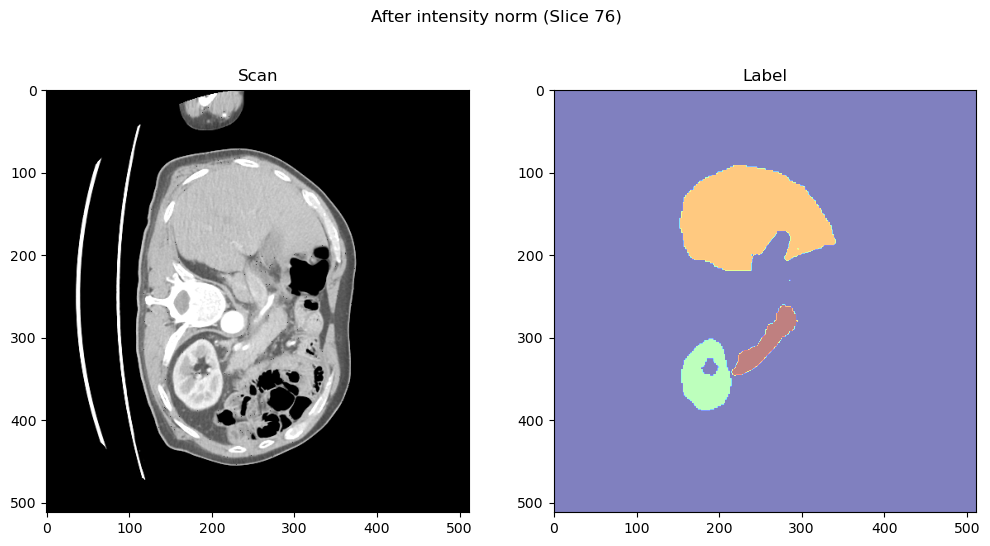

In [15]:
# 3. Intensities (clamping and normalization)
normalized = intensities(loaded)
scan = normalized['scan'][0]
label = normalized['label'][0]

slice_index = scan.shape[2] // 2  # Tomar la slice central como ejemplo
show_scan_and_label(scan[:, :, 76], label[:, :, 76], "After intensity norm (Slice 76)")

In [100]:
# 4. RandCropByPosNegLabeld
crop_transform = t.RandCropByPosNegLabeld(keys=('scan', 'label'), label_key='label', spatial_size=patch_size, num_samples=n_samples, pos=1, neg=neg_samples)
crop_list = crop_transform(normalized)

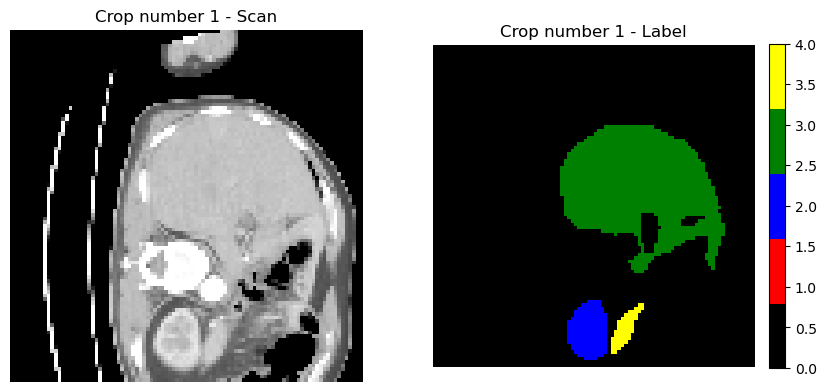

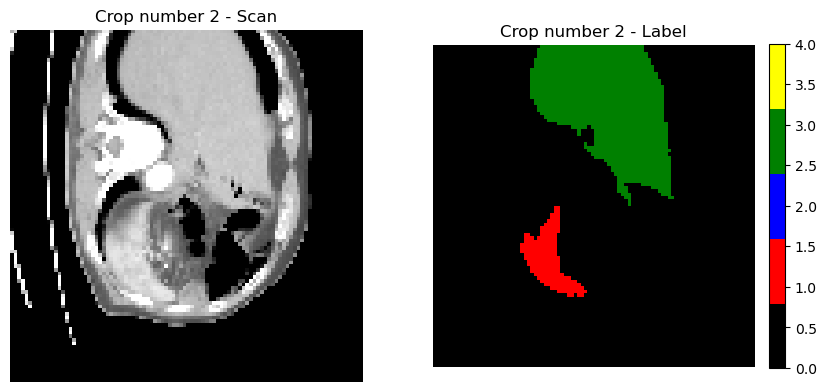

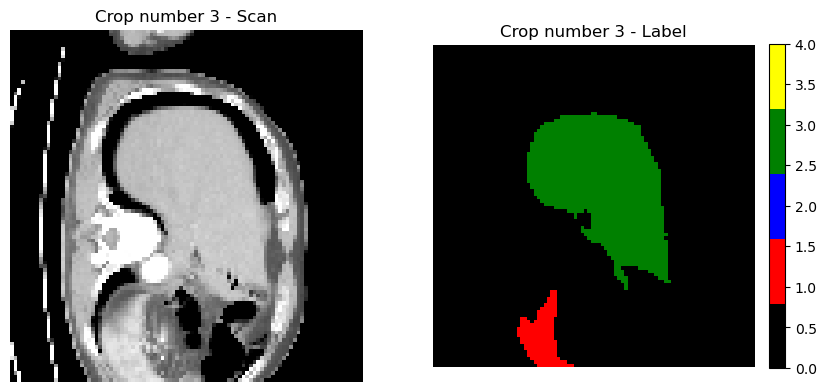

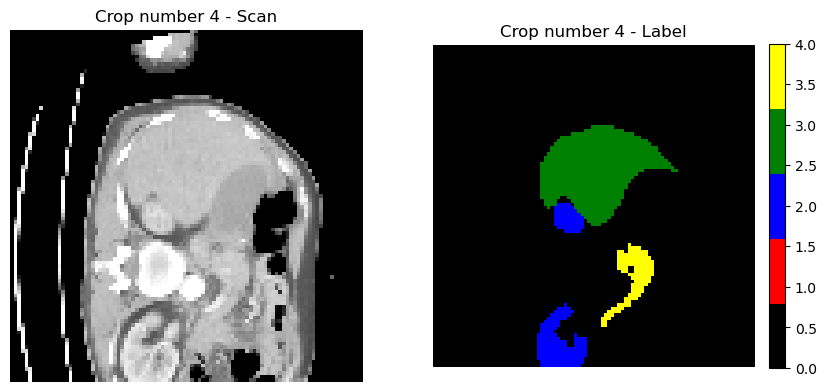

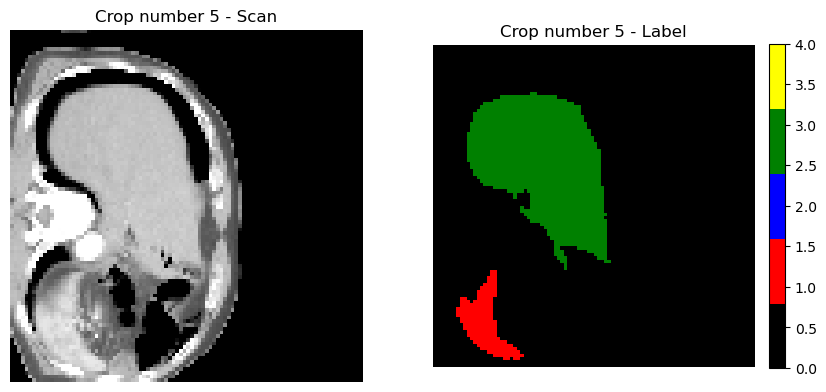

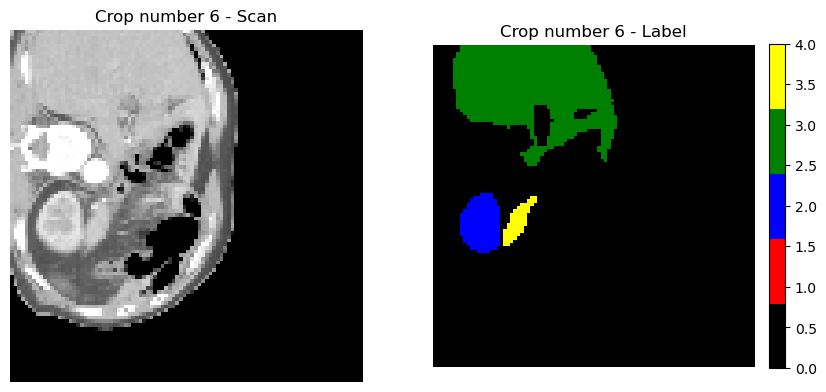

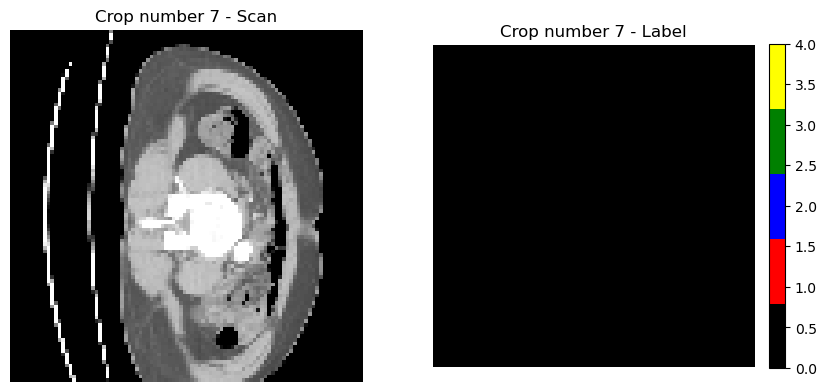

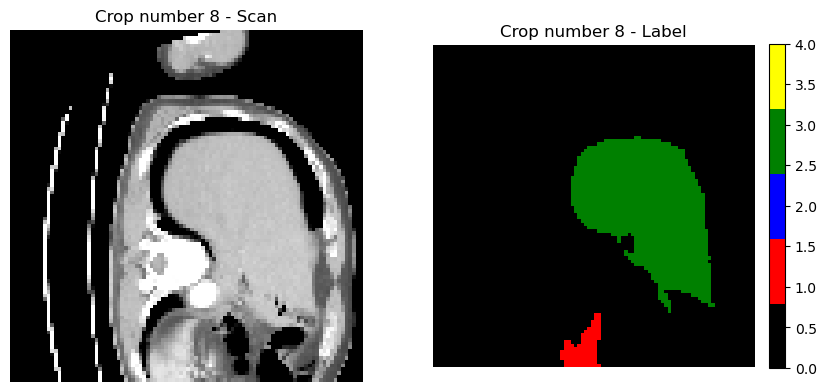

In [101]:
from matplotlib.colors import ListedColormap
crop_transform = t.RandCropByPosNegLabeld(keys=('scan', 'label'), label_key='label', spatial_size=patch_size, num_samples=n_samples, pos=1, neg=neg_samples)
crop_list = crop_transform(normalized)

# Define los colores para cada clase. El primer color puede ser para el fondo (clase 0), luego clase 1, clase 2, etc.
colors = ['black', 'red', 'blue', 'green','yellow']  # Ajusta esto según tus clases
cmap = ListedColormap(colors)

# También puedes definir un valor máximo para la barra de colores si tienes un número fijo de clases
vmin, vmax = 0, len(colors) - 1

def show_scan_and_label(scan, label, title="", cmap=None, vmin=None, vmax=None):
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    
    # Plot para la imagen del scan
    axes[0].imshow(scan, cmap='gray')
    axes[0].set_title(f'{title} - Scan')
    axes[0].axis('off')
    
    # Plot para la etiqueta (label) con colormap específico
    im = axes[1].imshow(label, cmap=cmap, vmin=vmin, vmax=vmax)
    axes[1].set_title(f'{title} - Label')
    axes[1].axis('off')
    
    # Mostrar la barra de colores
    plt.colorbar(im, ax=axes[1], fraction=0.046, pad=0.04)
    
    plt.show()

# Ejemplo de uso en el bucle
slice_index = 50  # O el índice de la slice que quieras usar
for idx, crop in enumerate(crop_list):  # Enumerar para obtener el índice y el diccionario de cada crop
    scan = crop['scan'][0]
    label = crop['label'][0]
    show_scan_and_label(scan[:, :, slice_index], label[:, :, slice_index], 
                        f"Crop number {idx + 1}", cmap=cmap, vmin=vmin, vmax=vmax)
